# A fast velocity computation

## Making a synthetic set

In [1]:
import MotionClouds as mc
N_X, N_Y, N_T = 64, 64, 256
fx, fy, ft = mc.get_grids(N_X, N_Y, N_T)
sf_0 = 0.05
env = mc.envelope_gabor(fx, fy, ft, sf_0=sf_0, B_sf=2.*sf_0, V_X=.5, V_Y=0., B_V=.5*mc.B_V)
z = 2 * mc.rectif(mc.random_cloud(env, seed=1973)) - 1

In [2]:
import numpy as np

In [3]:
slope = 4. 
movie = np.tanh(slope*z)

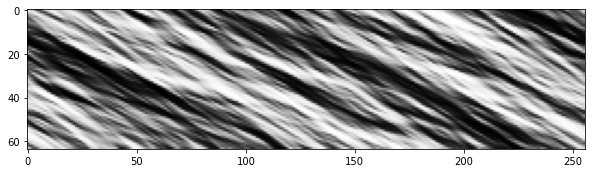

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(movie[:, 0, :], cmap=plt.gray())

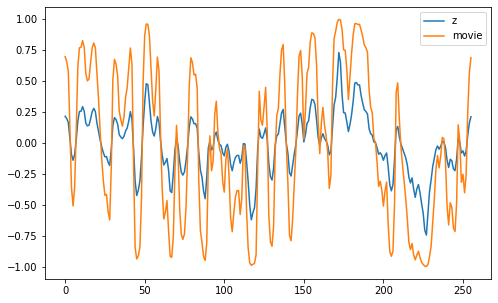

In [5]:
fig, ax = plt.subplots(figsize=(8, 5))
_ = ax.plot(z[0, 0, :], label='z')
_ = ax.plot(movie[0, 0, :], label='movie')
plt.legend();

In [6]:
noise = 0.025
movie += noise * np.random.randn(N_X, N_Y, N_T)

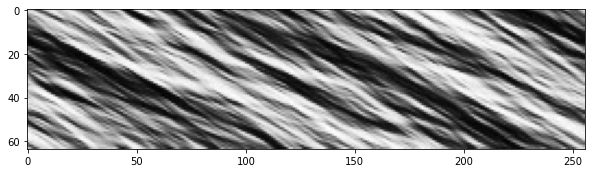

In [7]:
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(movie[:, 0, :], cmap=plt.gray())

## transform to events

In [8]:
print(movie.min(), movie.max())

-1.0798184884189759 1.0755603489080363


In [9]:
It = np.gradient(movie, axis=-1)

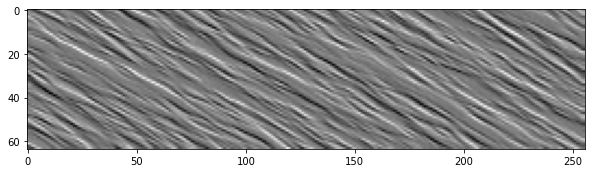

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(It[:, 0, :], cmap=plt.gray())

In [11]:
print(It.min(), It.max())

-0.9500964784143897 1.0926705544975277


In [12]:
threshold = 0.35

In [13]:
It_ = It.copy()
It_event = np.zeros((N_X, N_Y, N_T))
for i_T in range(N_T-1):
    It_event[:, :, i_T] = 1. * (It_[:, :, i_T] > threshold) - 1. * (It_[:, :, i_T] < -threshold)
    It_[:, :, i_T+1] -= threshold * It_event[:, :, i_T]

In [14]:
print(It_event.min(), It_event.max())
print(It_.min(), It_.max())

-1.0 1.0
-0.9500964784143897 1.0926705544975277


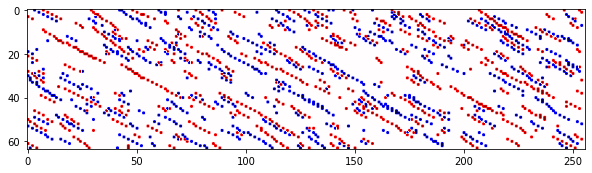

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(It_event[:, 0, :], cmap=plt.cm.seismic, vmin=-1, vmax=1)

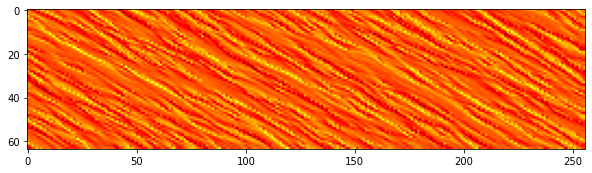

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(It_[:, 0, :], cmap=plt.hot(), vmin=-1, vmax=1)

## motion compensated transform on events

In [17]:
It_v = It_event.copy()
u, v = 1., 0.
for i_T in range(N_T):
    It_v[:, :, i_T] = np.roll(It_v[:, :, i_T], -int(u*i_T), axis=0)
    It_v[:, :, i_T] = np.roll(It_v[:, :, i_T], -int(v*i_T), axis=1)    

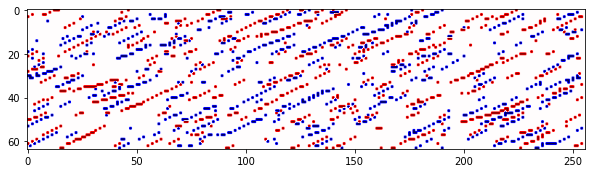

In [18]:
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(It_v[:, 0, :], cmap=plt.cm.seismic, vmin=-1, vmax=1)

## transform as an event list

In [19]:
It_event.shape

(64, 64, 256)

In [20]:
import torch

In [21]:
torch.nonzero(torch.Tensor(It_event)).shape, torch.nonzero(torch.Tensor(It_event==1)).shape, torch.nonzero(torch.Tensor(It_v==-1)).shape

(torch.Size([97194, 3]), torch.Size([48704, 3]), torch.Size([48490, 3]))

In [22]:
torch.nonzero(torch.Tensor(It_event))[100:110, :]

tensor([[ 0,  4, 29],
        [ 0,  4, 33],
        [ 0,  4, 38],
        [ 0,  4, 43],
        [ 0,  4, 47],
        [ 0,  4, 48],
        [ 0,  4, 54],
        [ 0,  4, 57],
        [ 0,  4, 60],
        [ 0,  4, 68]])

x, y, t, p

In [23]:
events = torch.nonzero(torch.Tensor(It_event))
events[:, 0].max(), events[:, 1].max(), events[:, 2].max()

(tensor(63), tensor(63), tensor(254))

In [24]:
events_neg = torch.nonzero(torch.Tensor(It_event==-1))
events_neg.shape, torch.ones(events_neg.shape[0], 1).shape

(torch.Size([48490, 3]), torch.Size([48490, 1]))

In [25]:
events_neg = torch.hstack((events_neg, -1 * torch.ones(events_neg.shape[0], 1, dtype=int)))
events_neg.shape

torch.Size([48490, 4])

In [26]:
events_pos = torch.nonzero(torch.Tensor(It_event==1))
events_pos = torch.hstack((events_pos, torch.ones(events_pos.shape[0], 1, dtype=int)))
events_pos.shape

torch.Size([48704, 4])

In [27]:
events = torch.vstack((events_pos, events_neg))
events.shape

torch.Size([97194, 4])

In [28]:
events[200:210, :]

tensor([[  0,  13,  69,   1],
        [  0,  13,  77,   1],
        [  0,  13,  98,   1],
        [  0,  13, 100,   1],
        [  0,  13, 119,   1],
        [  0,  13, 135,   1],
        [  0,  13, 144,   1],
        [  0,  13, 154,   1],
        [  0,  13, 168,   1],
        [  0,  13, 209,   1]])

In [29]:
times, indices = torch.sort(events[:, 2])
events = events[indices, :]

In [30]:
# x, y, t, p
events[200:210, :]

tensor([[20, 21,  0,  1],
        [50, 59,  0,  1],
        [20, 22,  0,  1],
        [ 3,  5,  0,  1],
        [50, 60,  0,  1],
        [20, 23,  0,  1],
        [40, 24,  0, -1],
        [20, 24,  0,  1],
        [ 6, 40,  0,  1],
        [50, 61,  0,  1]])

Visual check

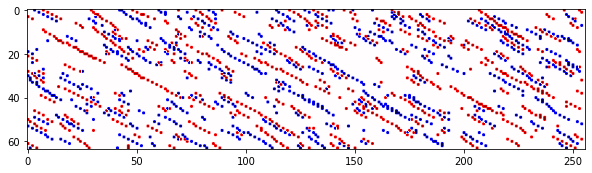

In [31]:
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(It_event[:, 0, :], cmap=plt.cm.seismic, vmin=-1, vmax=1)

In [32]:
It_event_ = torch.zeros((N_X, N_Y, N_T))
It_event_[events[:, 0], events[:, 1], events[:, 2]] = 1. * events[:, 3]

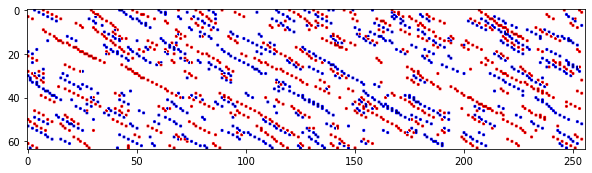

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(It_event_[:, 0, :], cmap=plt.cm.seismic, vmin=-1, vmax=1)

## construction of a constraint

In [34]:
events.shape

torch.Size([97194, 4])

In [35]:
x_ = torch.linspace(-10, N_X+10, 100)
x = torch.remainder(x_, N_X)
N_X, x.min(), x.max()

(64, tensor(0.1818), tensor(63.8182))

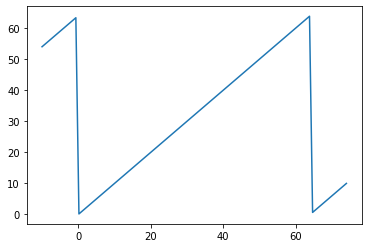

In [36]:
plt.plot(x_, x)

https://en.cppreference.com/w/cpp/numeric/math/fmod

In [37]:
u, v = 1., 0.
events_t = 1 * events.clone().detach()
events_t[:, 0] = torch.remainder(events_t[:, 0] - u*events_t[:, 2], N_X)
events_t[:, 1] = torch.remainder(events_t[:, 1] - v*events_t[:, 2], N_X)

In [38]:
events_t[:, 0].shape

torch.Size([97194])

In [39]:
It_event_ = torch.zeros((N_X, N_Y, N_T))
It_event_[events_t[:, 0], events_t[:, 1], events_t[:, 2]] = 1. * events_t[:, 3]

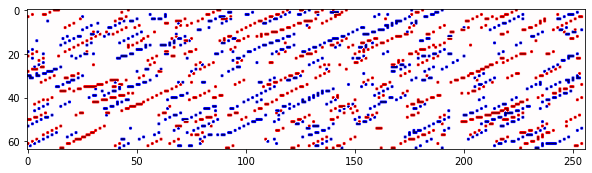

In [40]:
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(It_event_[:, 0, :], cmap=plt.cm.seismic, vmin=-1, vmax=1)

Compute occurences of events in space:


In [41]:
N_event = 200
x = events[:N_event, 0] - 1. * u*events[:N_event, 2]
y = events[:N_event, 1] - 1. * v*events[:N_event, 2]
#x

In [42]:
x = torch.remainder(x, N_X)
y = torch.remainder(y, N_Y)
x, x.shape

(tensor([53.,  8.,  8.,  2.,  8.,  8.,  8.,  8., 62., 30.,  8.,  2.,  8.,  2.,
          8., 62., 30., 30.,  8., 49.,  8., 49.,  3., 30., 49., 30., 49.,  2.,
          8., 62., 30., 49.,  7.,  7.,  7.,  7.,  7.,  7., 30.,  7.,  7.,  2.,
          5., 62., 49., 49.,  2., 46., 49., 30., 46., 49., 49., 62.,  2.,  2.,
         50.,  2., 49.,  2.,  2., 49.,  2., 49., 49., 62.,  2., 30., 17., 30.,
          2., 31., 50.,  2., 50., 31., 50., 50., 48., 10., 10., 10., 10., 10.,
         18.,  5.,  5., 10., 31., 49., 46., 31.,  2., 27., 27.,  3., 46., 49.,
         46., 48., 48., 46., 31., 49., 46., 34., 46., 31.,  6., 48., 57.,  2.,
         31., 50., 46.,  5.,  5.,  5.,  6., 50.,  5., 34.,  5.,  5., 50., 48.,
          5., 34.,  6., 50.,  3., 31.,  6., 57., 31.,  6., 19., 19., 19., 19.,
         19.,  2., 19., 19., 27., 27., 19., 27., 19., 40., 19., 27., 19., 19.,
         27., 48., 19., 57., 19., 19., 19., 19., 40., 19., 34., 19., 31., 48.,
         31., 46., 48., 20., 20., 40., 20., 46., 20.

In [43]:
d = (x[:, None] - x[None, :])**2 + (y[:, None] - y[None, :])**2

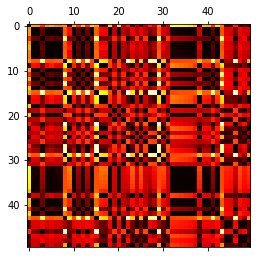

In [44]:
plt.matshow(d[:50, :50]);

In [45]:
import torch.nn.functional as F
from torch import nn

In [46]:
events_sub = events[:N_event]
for u in [0, .5, 1, 1.5]:
    for p in [-1, 1]:
        ind_p = events_sub[:, 3] == p
        x = events_sub[ind_p, 0] - 1. * u*events_sub[ind_p, 2]
        y = events_sub[ind_p, 1] - 1. * v*events_sub[ind_p, 2]
        x = torch.remainder(x, N_X)
        y = torch.remainder(y, N_Y)
        d = (x[:, None] - x[None, :])**2 + (y[:, None] - y[None, :])**2
        print(f'{u=:.2f}, {p=}, {d.mean().item():.2f}, {d.quantile(.2, axis=1).mean():.2f}')

u=0.00, p=-1, 1378.81, 373.59
u=0.00, p=1, 1167.08, 291.98
u=0.50, p=-1, 1378.81, 373.59
u=0.50, p=1, 1167.08, 291.98
u=1.00, p=-1, 1378.81, 373.59
u=1.00, p=1, 1167.08, 291.98
u=1.50, p=-1, 1378.81, 373.59
u=1.50, p=1, 1167.08, 291.98


## gradient descent optimization

In [47]:
import torch
torch.set_default_tensor_type("torch.DoubleTensor")

In [48]:
class EMD(torch.nn.Module):
    def __init__(self, u=0.7, v=0.):
        super(EMD, self).__init__()
        self.u = torch.nn.Parameter(u * torch.ones(1), requires_grad=True)
        self.v = torch.nn.Parameter(v * torch.ones(1), requires_grad=True)
        self.polarities = [-1, 1]
        
    def forward(self, events):
        loss = 0
        for p in self.polarities:
            ind_p = (events[:, 3] == p)
            x = events[ind_p, 0] - 1. * self.u * events[ind_p, 2]
            y = events[ind_p, 1] - 1. * self.v * events[ind_p, 2]
            x = torch.remainder(x, N_X)
            y = torch.remainder(y, N_Y)
            d = (x[:, None] - x[None, :])**2 + (y[:, None] - y[None, :])**2
            loss += d.quantile(.2, axis=1).sqrt().mean()/ torch.sqrt(d.mean())
            # loss += torch.sqrt(d.median(axis=1).mean()) / torch.sqrt(d.mean())
        return loss

In [49]:
learning_rate = 0.01
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 10 + 1

def fit_data(events, learning_rate=learning_rate, 
             num_epochs=num_epochs, betas=betas, verbose=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    N_X, N_Y, N_T = It_event.shape
    events = events.to(device)
        
    emd = EMD()
    emd = emd.to(device)
    emd.train()
    
    # optimizer = torch.optim.Adam(emd.parameters(), lr=learning_rate, betas=betas)
    optimizer = torch.optim.SGD(emd.parameters(), lr=learning_rate)
    # optimizer = torch.optim.Adam(emd.parameters(), lr=learning_rate)
    
    for epoch in range(int(num_epochs)):
        loss = emd(events)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - u={emd.u.detach().item():.3f} v={emd.v.detach().item():.3f} / Loss: {loss.item():.3f}")
    return emd, loss

N_event = 5000
events_sub = events[:N_event]
emd, loss = fit_data(events_sub, verbose=True)

Iteration: 0 - u=0.700 v=0.000 / Loss: 1.032
Iteration: 32 - u=0.700 v=0.001 / Loss: 1.033
Iteration: 64 - u=0.699 v=0.003 / Loss: 1.033
Iteration: 96 - u=0.699 v=0.004 / Loss: 1.033
Iteration: 128 - u=0.699 v=0.005 / Loss: 1.033
Iteration: 160 - u=0.698 v=0.006 / Loss: 1.033
Iteration: 192 - u=0.697 v=0.006 / Loss: 1.033
Iteration: 224 - u=0.696 v=0.007 / Loss: 1.033
Iteration: 256 - u=0.695 v=0.007 / Loss: 1.033
Iteration: 288 - u=0.694 v=0.009 / Loss: 1.033
Iteration: 320 - u=0.693 v=0.010 / Loss: 1.033
Iteration: 352 - u=0.692 v=0.012 / Loss: 1.032
Iteration: 384 - u=0.691 v=0.014 / Loss: 1.032
Iteration: 416 - u=0.690 v=0.015 / Loss: 1.032
Iteration: 448 - u=0.690 v=0.017 / Loss: 1.032
Iteration: 480 - u=0.690 v=0.018 / Loss: 1.032
Iteration: 512 - u=0.690 v=0.020 / Loss: 1.032
Iteration: 544 - u=0.690 v=0.021 / Loss: 1.032
Iteration: 576 - u=0.690 v=0.022 / Loss: 1.032
Iteration: 608 - u=0.689 v=0.023 / Loss: 1.032
Iteration: 640 - u=0.689 v=0.024 / Loss: 1.032
Iteration: 672 - u

In [50]:
emd.u, emd.v

(Parameter containing:
 tensor([0.6882], requires_grad=True),
 Parameter containing:
 tensor([0.0312], requires_grad=True))

In [51]:
events.shape

torch.Size([97194, 4])

In [52]:
u, v = [], []
for i_event in range(events.shape[0]//N_event):
    events_sub = events[(i_event*N_event):((i_event+1)*N_event)]
    emd, loss = fit_data(events_sub, verbose=False)
    print(f"Event: {i_event} - u={emd.u.detach().item():.3f} v={emd.v.detach().item():.3f} / Loss: {loss.item():.3f}")
    u.append(emd.u.detach().item())
    v.append(emd.v.detach().item())

Event: 0 - u=0.688 v=0.031 / Loss: 1.032
Event: 1 - u=0.761 v=0.009 / Loss: 1.029
Event: 2 - u=0.699 v=0.002 / Loss: 1.030
Event: 3 - u=0.700 v=-0.002 / Loss: 1.043
Event: 4 - u=0.698 v=0.000 / Loss: 1.045
Event: 5 - u=0.697 v=-0.014 / Loss: 1.027
Event: 6 - u=0.695 v=0.003 / Loss: 1.021
Event: 7 - u=0.701 v=0.001 / Loss: 1.020
Event: 8 - u=0.659 v=-0.039 / Loss: 1.008
Event: 9 - u=0.687 v=-0.000 / Loss: 1.006
Event: 10 - u=0.634 v=-0.040 / Loss: 1.009
Event: 11 - u=0.740 v=0.050 / Loss: 1.051
Event: 12 - u=0.697 v=0.000 / Loss: 1.051
Event: 13 - u=0.711 v=-0.018 / Loss: 0.997
Event: 14 - u=0.701 v=-0.001 / Loss: 1.005
Event: 15 - u=0.639 v=0.015 / Loss: 1.045
Event: 16 - u=0.709 v=0.002 / Loss: 1.049
Event: 17 - u=0.700 v=-0.002 / Loss: 1.027
Event: 18 - u=0.776 v=-0.012 / Loss: 1.040
